In [32]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import Huber
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(22)
random.seed(22)
tf.random.set_seed(22)

# Load data
df = pd.read_csv('all_numerical_perfect.csv', index_col='name')

In [33]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=22)

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the training data (fit on training data only to avoid data leakage)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale the test data using the same scaler (to maintain consistency)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [34]:
def create_autoencoder(latent_space_size):
    input_layer = layers.Input(shape=(X_train_scaled.shape[1],))  # Same as input data shape

    # Encoder
    encoded = layers.Dense(latent_space_size, activation='relu')(input_layer)
    # Decoder
    decoded = layers.Dense(X_train_scaled.shape[1], activation='sigmoid')(encoded)

    # Create the model
    autoencoder = Model(input_layer, decoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss=Huber())
    
    return autoencoder, input_layer, encoded

In [35]:
#Latent space sizes to experiment with
# latent_space_sizes = [8, 16, 32]

# # Dictionary to store the results
# results = {}

# for latent_size in latent_space_sizes:
#     print(f"\nTraining Autoencoder with Latent Space Size: {latent_size}")
    
#     # Create and train the autoencoder
#     autoencoder, input_layer, encoded = create_autoencoder(latent_size)
#     history = autoencoder.fit(X_train_scaled, X_train_scaled,
#                               validation_data=(X_test_scaled, X_test_scaled),
#                               epochs=50, batch_size=256, shuffle=True, verbose=0)
    
#     # Store the final val_loss for comparison
#     final_val_loss = history.history['val_loss'][-1]
#     results[latent_size] = final_val_loss
#     print(f"Final Validation Loss for Latent Size {latent_size}: {final_val_loss}")

In [36]:
# for latent_size, val_loss in results.items():
#     print(f"Latent Space Size: {latent_size}, Validation Loss: {val_loss}")

In [37]:
autoencoder, input_layer, encoded = create_autoencoder(16)

# Fit the autoencoder model
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          validation_data=(X_test_scaled, X_test_scaled),
                          epochs=50, batch_size=256, shuffle=True, verbose=0)

# Create the encoder model to extract the latent features
encoder = Model(input_layer, encoded)

# Get the latent features for both train and test data
X_train_latent = encoder.predict(X_train_scaled)
X_test_latent = encoder.predict(X_test_scaled)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


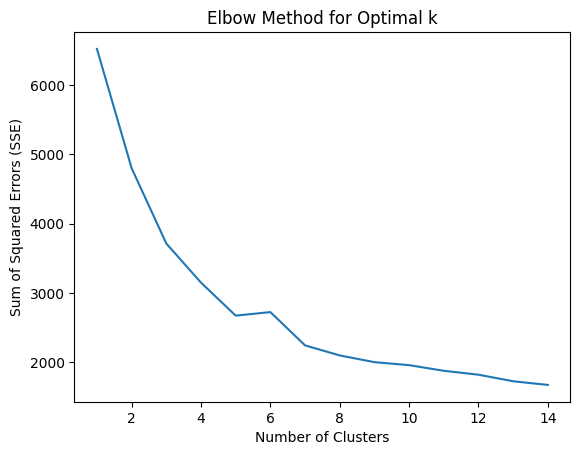

In [38]:
sse = []

# Try different values of k (number of clusters)
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(X_train_latent)  # Use latent features for clustering
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 15), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

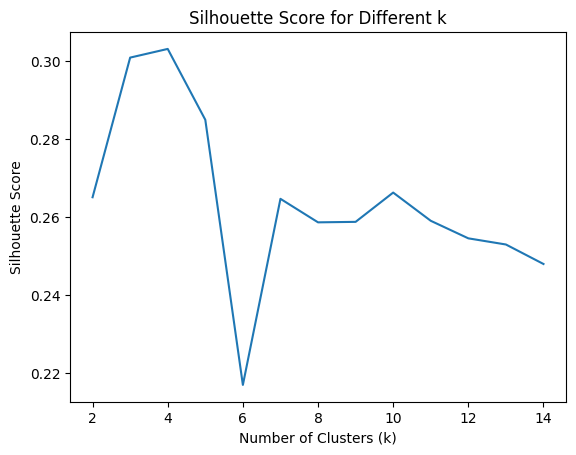

The best number of clusters (k) is: 4


In [39]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# List to store silhouette scores
k_sil_scores = []

# Try different values of k (number of clusters)
for k in range(2, 15):  # You can try different ranges depending on your data
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(X_train_latent)  # Fit K-means on the latent features
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    score = silhouette_score(X_train_latent, cluster_labels)
    k_sil_scores.append(score)

# Plot silhouette scores for different k values
plt.plot(range(2, 15), k_sil_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Varying k (All Genres Dataset)')
plt.savefig('Graphs/silhouette_score_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the best k (the one with the highest silhouette score)
best_k = range(2, 15)[k_sil_scores.index(max(k_sil_scores))]
print(f"The best number of clusters (k) is: {best_k}")

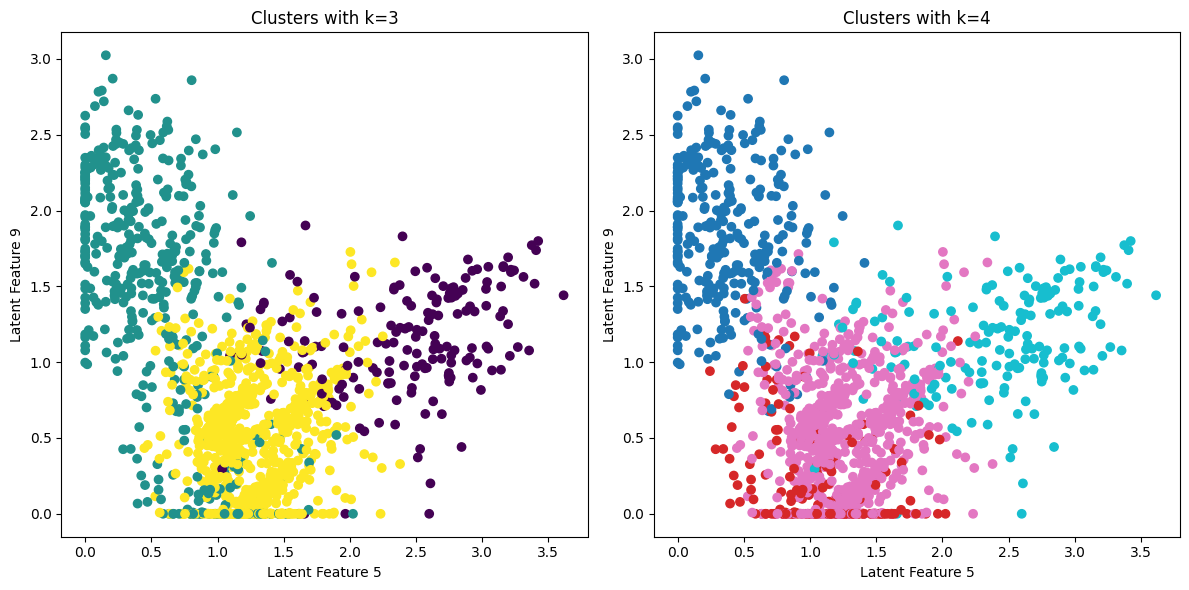

In [40]:
# Perform K-means clustering with k=2 and k=7
kmeans_3 = KMeans(n_clusters=3, random_state=22)
kmeans_3.fit(X_train_latent)
cluster_labels_3 = kmeans_3.labels_

kmeans_4 = KMeans(n_clusters=4, random_state=22)
kmeans_4.fit(X_train_latent)
cluster_labels_4 = kmeans_4.labels_

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for k=2
axs[0].scatter(X_train_latent[:, 5], X_train_latent[:, 8], c=cluster_labels_3, cmap='viridis')
axs[0].set_title('Clusters with k=3')
axs[0].set_xlabel('Latent Feature 5')
axs[0].set_ylabel('Latent Feature 9')

# Plot for k=7
axs[1].scatter(X_train_latent[:, 5], X_train_latent[:, 8], c=cluster_labels_4, cmap='tab10')
axs[1].set_title('Clusters with k=4')
axs[1].set_xlabel('Latent Feature 5')
axs[1].set_ylabel('Latent Feature 9')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('Graphs/k=3 k=4 scatter.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [41]:
cluster_sizes_3 = [sum(cluster_labels_3 == i) for i in range(3)]
print(f"Cluster sizes for k=3: {cluster_sizes_3}")

# For k=7
cluster_sizes_4 = [sum(cluster_labels_4 == i) for i in range(4)]
print(f"Cluster sizes for k=4: {cluster_sizes_4}")

Cluster sizes for k=3: [177, 448, 747]
Cluster sizes for k=4: [307, 191, 699, 175]


In [42]:
# Convert the latent space (X_train_latent) to a DataFrame
df_k3 = pd.DataFrame(X_train_latent)  # Convert to DataFrame
df_k4 = pd.DataFrame(X_train_latent)

# Add cluster labels to the DataFrame
df_k3['Cluster_Labels_3'] = cluster_labels_3  # Add the cluster labels for k=2
df_k4['Cluster_Labels_4'] = cluster_labels_4  # Add the cluster labels for k=7

# Calculate the mean values for each feature per cluster (k=2)
cluster_means_3 = df_k3.groupby('Cluster_Labels_3').mean()

# Calculate the mean values for each feature per cluster (k=7)
cluster_means_4 = df_k4.groupby('Cluster_Labels_4').mean()

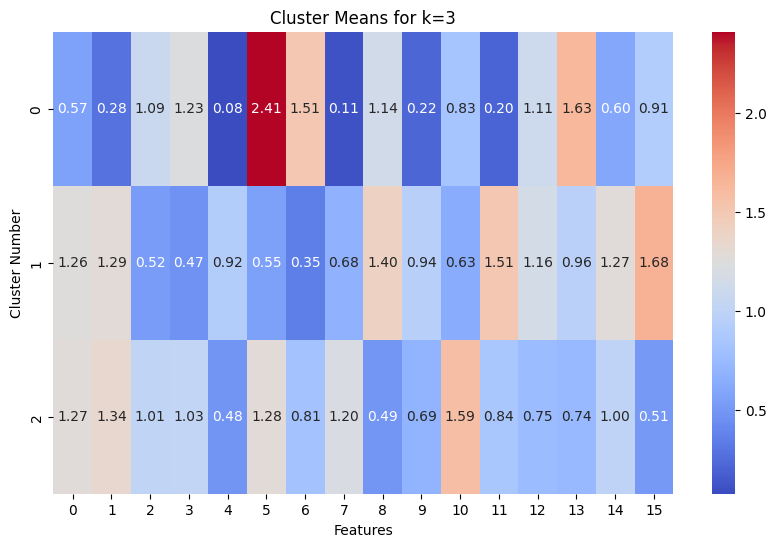

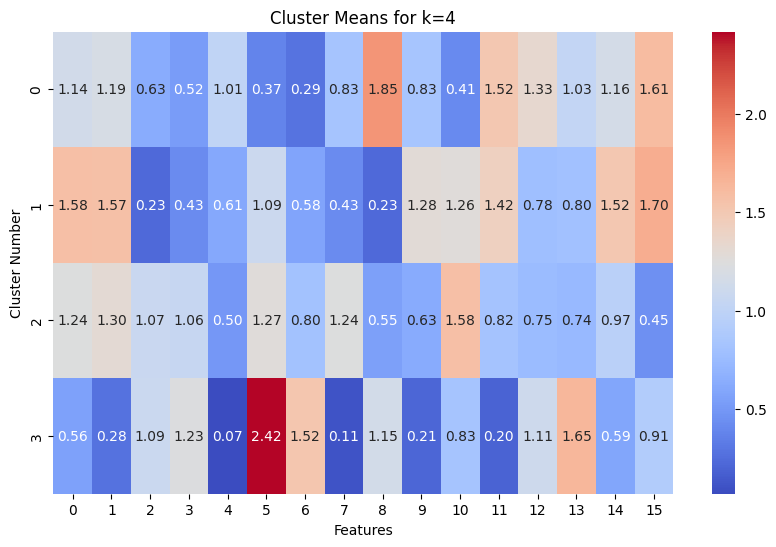

In [43]:
import seaborn as sns
# Heatmap for k=2
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_3, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Cluster Means for k=3")
plt.xlabel("Features")
plt.ylabel("Cluster Number")
plt.savefig('Graphs/k=3_latent.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap for k=7
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_4, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Cluster Means for k=4")
plt.xlabel("Features")
plt.ylabel("Cluster Number")
plt.savefig('Graphs/k=4_latent.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(df['score'], bins=30, color='blue', alpha=0.7, label='Original Feature 0')
# plt.title('User Score')

# plt.subplot(1, 2, 2)
# plt.hist(X_train_latent[:, 0], bins=30, color='green', alpha=0.7, label='Latent Space Feature 1')
# plt.title('Latent Space Feature 1')
# plt.show()

In [45]:
test_labels_4 = kmeans_4.predict(X_test_latent)
print(test_labels_4)

[2 3 2 2 0 3 2 2 0 1 2 0 2 2 2 2 0 3 2 2 1 0 1 1 2 2 2 2 0 2 2 2 0 0 2 2 0
 2 2 1 0 2 2 3 2 2 2 3 2 2 0 2 1 0 0 2 2 2 2 2 2 3 1 1 3 2 2 1 3 2 2 0 2 2
 0 2 0 0 1 1 2 0 2 3 3 2 2 2 0 3 1 2 1 1 2 2 2 2 1 1 2 1 2 0 0 1 2 0 2 2 2
 0 0 2 2 2 2 2 1 3 2 2 0 1 2 2 2 2 2 3 2 0 0 2 2 0 2 0 2 2 2 2 1 2 3 1 2 0
 2 3 0 0 0 1 1 0 2 1 0 2 2 2 2 2 2 3 1 0 3 2 3 2 3 0 2 2 3 2 2 0 2 2 0 2 0
 0 2 2 0 2 2 0 1 0 2 2 2 0 2 1 1 0 2 2 2 2 1 0 0 2 1 1 2 1 3 3 0 2 2 2 3 0
 2 0 3 3 3 2 2 0 0 2 1 1 0 2 0 2 3 3 2 0 2 1 0 2 1 1 2 2 2 2 3 2 2 2 2 2 0
 2 2 2 2 1 3 2 2 3 1 3 1 2 2 2 0 0 2 0 3 2 2 2 2 2 0 1 0 0 2 1 3 2 2 3 2 2
 2 2 3 0 0 2 3 2 3 0 0 2 1 2 3 1 1 0 0 1 3 0 3 2 0 1 2 2 0 2 2 1 2 2 0 2 2
 2 3 2 2 2 2 3 0 2 0]


In [46]:
cluster_test_4 = [sum(test_labels_4 == i) for i in range(4)]
print(f"Cluster sizes on test data for k=4: {cluster_test_4}")

Cluster sizes on test data for k=4: [76, 49, 175, 43]


In [47]:
total_cluster_size = [a + b for a, b in zip(cluster_sizes_4, cluster_test_4)]
print(total_cluster_size)

[383, 240, 874, 218]
